# Final Project: Load balancing
## Part 2 : Tabular Model-Free control

#### Q-Learning

Author : Jed MOUTAHIR

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
class LoadBalencingEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, lambdA, mu1, mu2, gamma, Q1_max, Q2_max):
        self.lambdA = lambdA
        self.mu1 = mu1
        self.mu2 = mu2
        self.gamma = gamma
        self.Q1 = 0
        self.Q2 = 0
        self.state = (self.Q1, self.Q2)

        self.actions = np.arange(2)     # define set of actions
        self.Q1_max = Q1_max
        self.Q2_max = Q2_max

    def reward(self):
        return - (self.state[0] + self.state[1])
    
    def step(self, action):
        # Take action (0 or 1) and return reward.
        event = np.random.uniform()

        # Is there a departure?
        if(event < self.mu1 and self.Q1 > 0):
            self.Q1 -= 1
        elif(event < self.mu1 + self.mu2 and self.Q2 > 0):
            self.Q2 -= 1

        # Is there an arrival?
        elif(self.Q1 < self.Q1_max and self.Q2 < self.Q2_max and event < self.mu1 + self.mu2 + self.lambdA):
            # Choose queue
            if(self.Q1 == self.Q1_max):
                self.Q2 += 1
            elif(self.Q2 == self.Q2_max):
                self.Q1 += 1
            elif(action == 0):
                self.Q1 += 1
            elif(action == 1):
                self.Q2 += 1
        else:
            if((self.Q1 > self.Q1_max or self.Q2 > self.Q2_max) and (event < self.mu1 + self.mu2 + self.lambdA)):
                print("Error: impossible state : ")
                print("Q1 = ", self.Q1)
                print("Q2 = ", self.Q2)
                print("event = ", event)
                print("action = ", action)
                print("lambdA = ", self.lambdA)
                print("mu1 = ", self.mu1)
                print("mu2 = ", self.mu2)

        self.state = (self.Q1, self.Q2)
        reward = self.reward()

        return reward, self.state

In [231]:
def QL(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, num_episodes, num_steps, alpha=0.1, eps=1e-5):
    """ Function that implements the Q-Learning algorithm. """

    # Initialize environment
    env = LoadBalencingEnv(lambdA, mu1, mu2, gamma, Q1_max, Q2_max)

    # Initialize value function with zeros
    V = np.zeros((env.Q1_max+1, env.Q2_max+1, len(env.actions)))

    # Initialise the policy
    policy = np.zeros((env.Q1_max+1, env.Q2_max+1, len(env.actions)))
    policy[:, :, 0] = 0.5
    policy[:, :, 1] = 0.5

    # Visited states
    visited_states = np.zeros((env.Q1_max+1, env.Q2_max+1, len(env.actions)))

    for i in np.arange(num_episodes):
        # Print the pourcentage of episodes done
        if(i % (num_episodes/10) == 0):
            print("Episode ", i, "/", num_episodes)

        # Initial state
        # Random initial state
        state = (np.random.randint(0, env.Q1_max+1), np.random.randint(0, env.Q2_max+1))

        visited_states[state[0], state[1], :] += 1

        for j in np.arange(num_steps):

            # Choose action based on the computed policy
            action = np.random.choice(env.actions, p=policy[state[0], state[1], :])

            # Next state and reward
            reward, next_state = env.step(action)

            visited_states[next_state[0], next_state[1], :] += 1

            # Update value function
            V[state[0], state[1], action] += alpha/(j+1)*(reward + gamma*np.max(V[next_state[0], next_state[1], :]) - V[state[0], state[1], action])

            # Update state
            state = next_state

            # Update policy
            policy[state[0], state[1], :] = np.zeros(len(env.actions))
            if(V[state[0], state[1], 0] > V[state[0], state[1], 1]):
                policy[state[0], state[1], 0] = 1
                policy[state[0], state[1], 1] = 0
            elif(V[state[0], state[1], 0] < V[state[0], state[1], 1]):
                policy[state[0], state[1], 1] = 1
                policy[state[0], state[1], 0] = 0
            else:
                policy[state[0], state[1], 0] = 0.5
                policy[state[0], state[1], 1] = 0.5
            
    
    # Compute the optimal policy
    policy = np.zeros((env.Q1_max+1, env.Q2_max+1))
    for i in np.arange(env.Q1_max+1):
        for j in np.arange(env.Q2_max+1):
            if(V[i, j, 0] > V[i, j, 1]):
                policy[i, j] = 0
            elif(V[i, j, 0] < V[i, j, 1]):
                policy[i, j] = 1
            else:
                policy[i, j] = 0.5

    return V, policy, visited_states

In [232]:
# Parameters
lambdA = 0.4
mu1 = 0.2
mu2 = 0.2
gamma = 0.99
Q1_max = 20
Q2_max = 20

In [233]:
# Compute optimal policy using Q-Learning
N = 1000000
V, policy, visited_states = QL(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N, 1)

Episode  0 / 1000000
Episode  100000 / 1000000
Episode  200000 / 1000000
Episode  300000 / 1000000
Episode  400000 / 1000000
Episode  500000 / 1000000
Episode  600000 / 1000000
Episode  700000 / 1000000
Episode  800000 / 1000000
Episode  900000 / 1000000


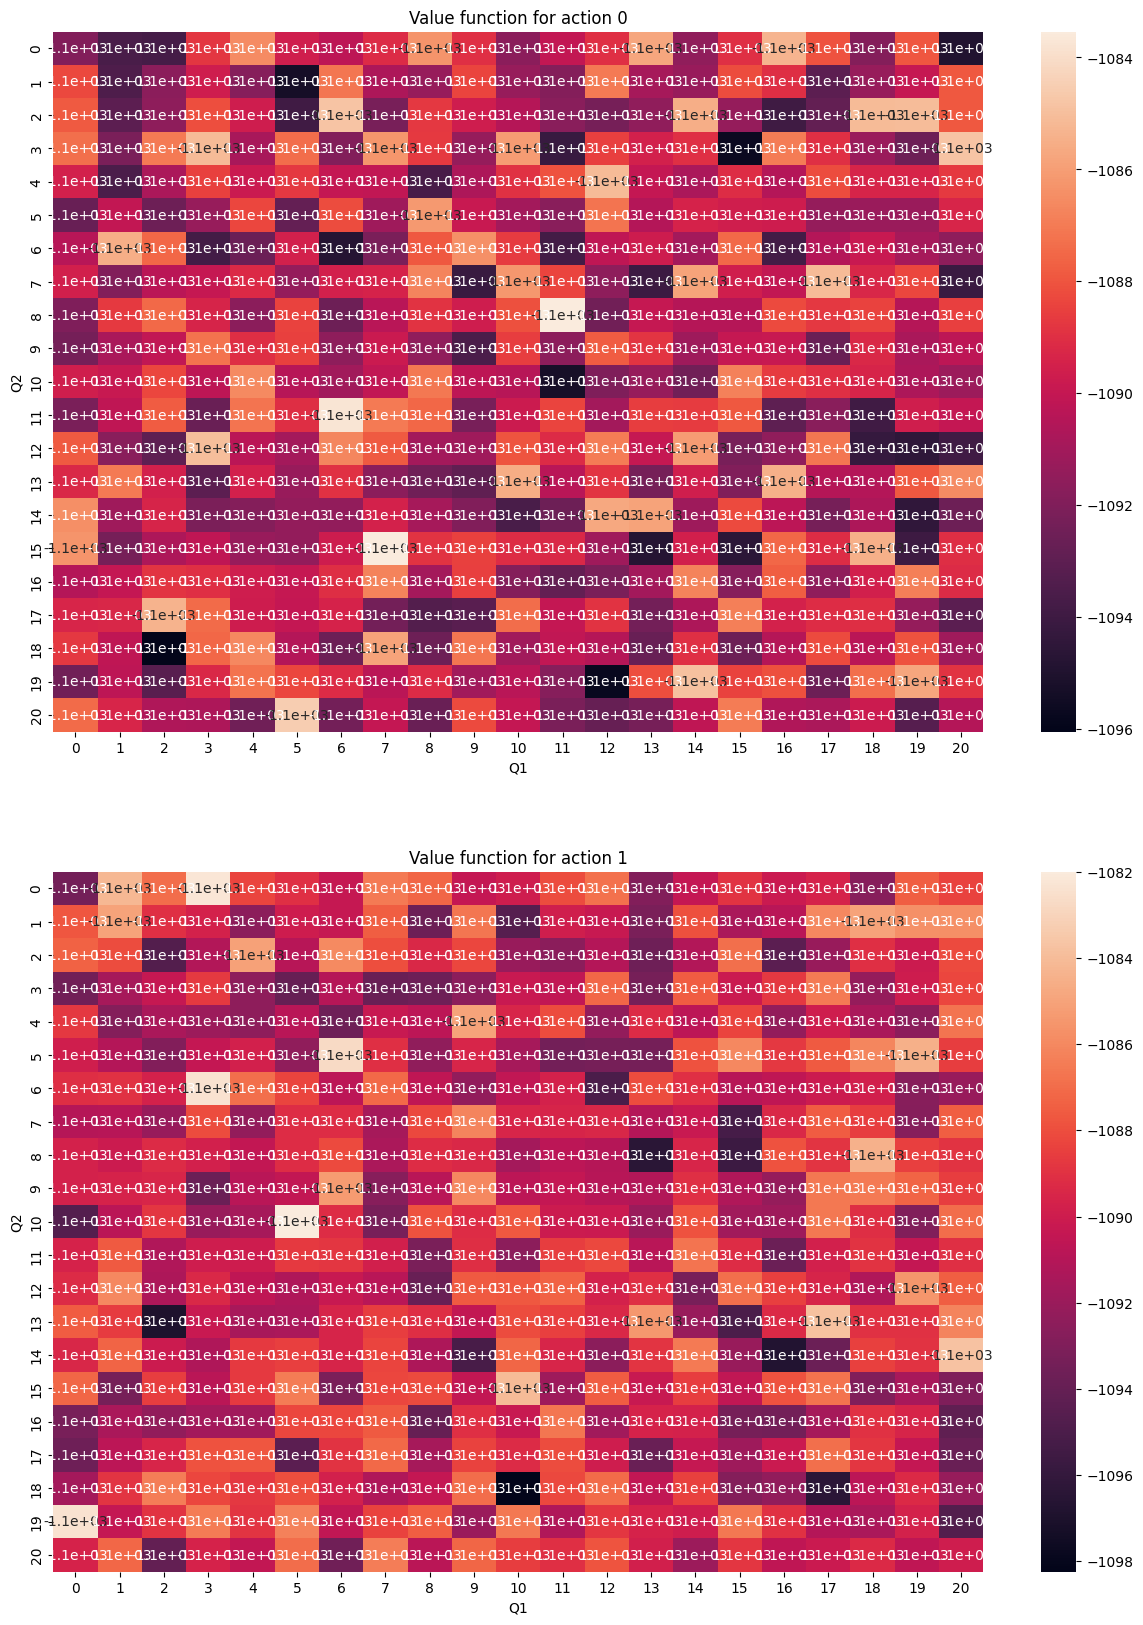

In [234]:
# Plot the value function using sns
fig, ax = plt.subplots(2, 1, figsize=(15, 20))
sns.heatmap(V[:, :, 0], ax=ax[0], annot=True)
sns.heatmap(V[:, :, 1], ax=ax[1], annot=True)
ax[0].set_title("Value function for action 0")
ax[1].set_title("Value function for action 1")
ax[0].set_xlabel("Q1")
ax[0].set_ylabel("Q2")
ax[1].set_xlabel("Q1")
ax[1].set_ylabel("Q2")
plt.show()

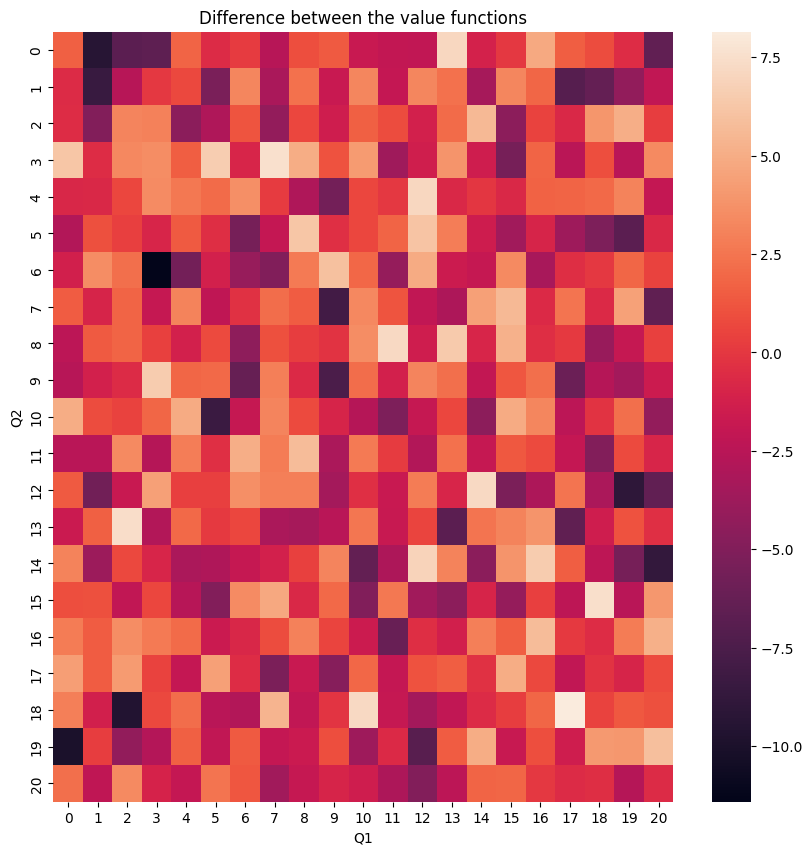

In [235]:
# Plot the difference between the value functions
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(V[:, :, 0] - V[:, :, 1])
ax.set_title("Difference between the value functions")
ax.set_xlabel("Q1")
ax.set_ylabel("Q2")
plt.show()

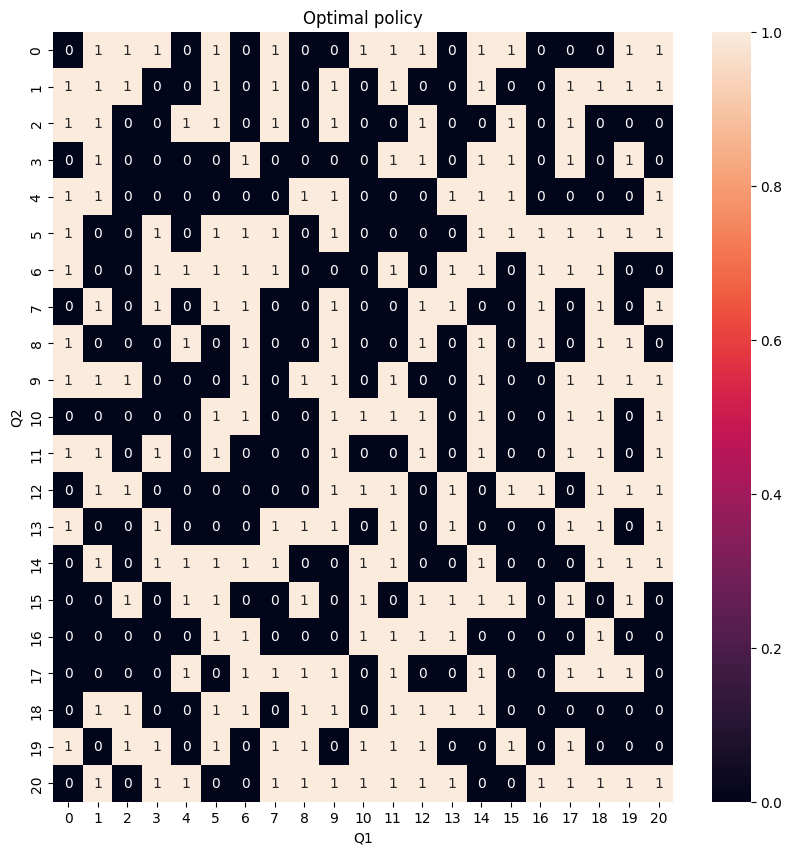

In [236]:
# Plot the optimal policy
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(policy, annot=True, ax=ax)
ax.set_title("Optimal policy")
ax.set_xlabel("Q1")
ax.set_ylabel("Q2")
plt.show()

In [237]:
# Compute the optimal policy using the value function
optimal_policy = np.zeros((Q1_max+1, Q2_max+1))
for i in np.arange(Q1_max+1):
    for j in np.arange(Q2_max+1):
        if(V[i, j, 0] > V[i, j, 1]):
            optimal_policy[i, j] = 0
        elif(V[i, j, 0] < V[i, j, 1]):
            optimal_policy[i, j] = 1
        else:
            optimal_policy[i, j] = 0.5

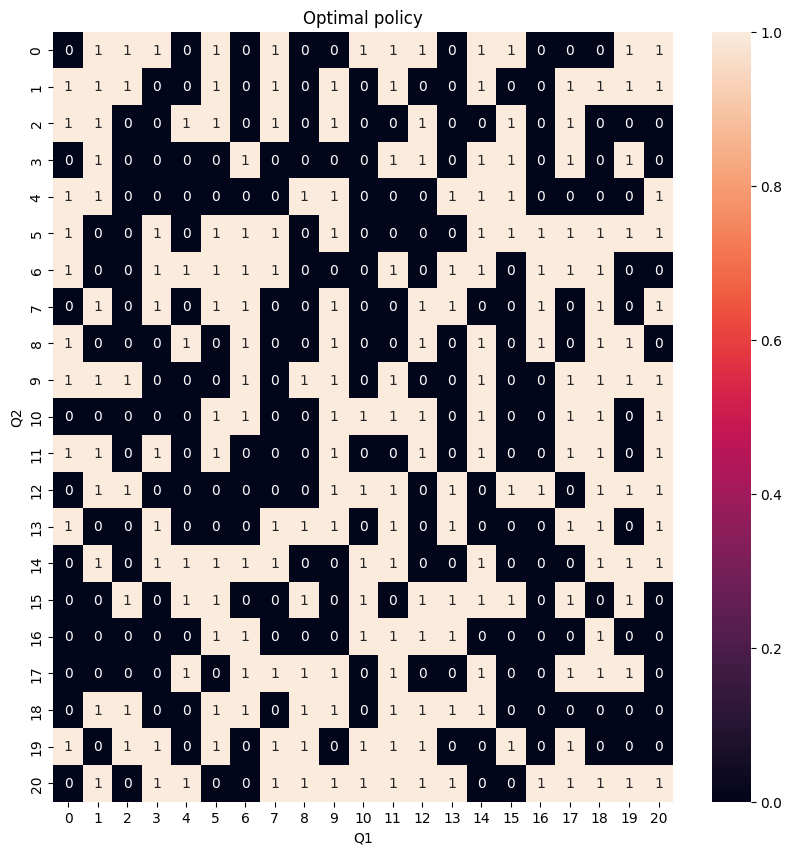

In [238]:
# Plot the optimal policy
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(optimal_policy, annot=True, ax=ax)
ax.set_title("Optimal policy")
ax.set_xlabel("Q1")
ax.set_ylabel("Q2")
plt.show()

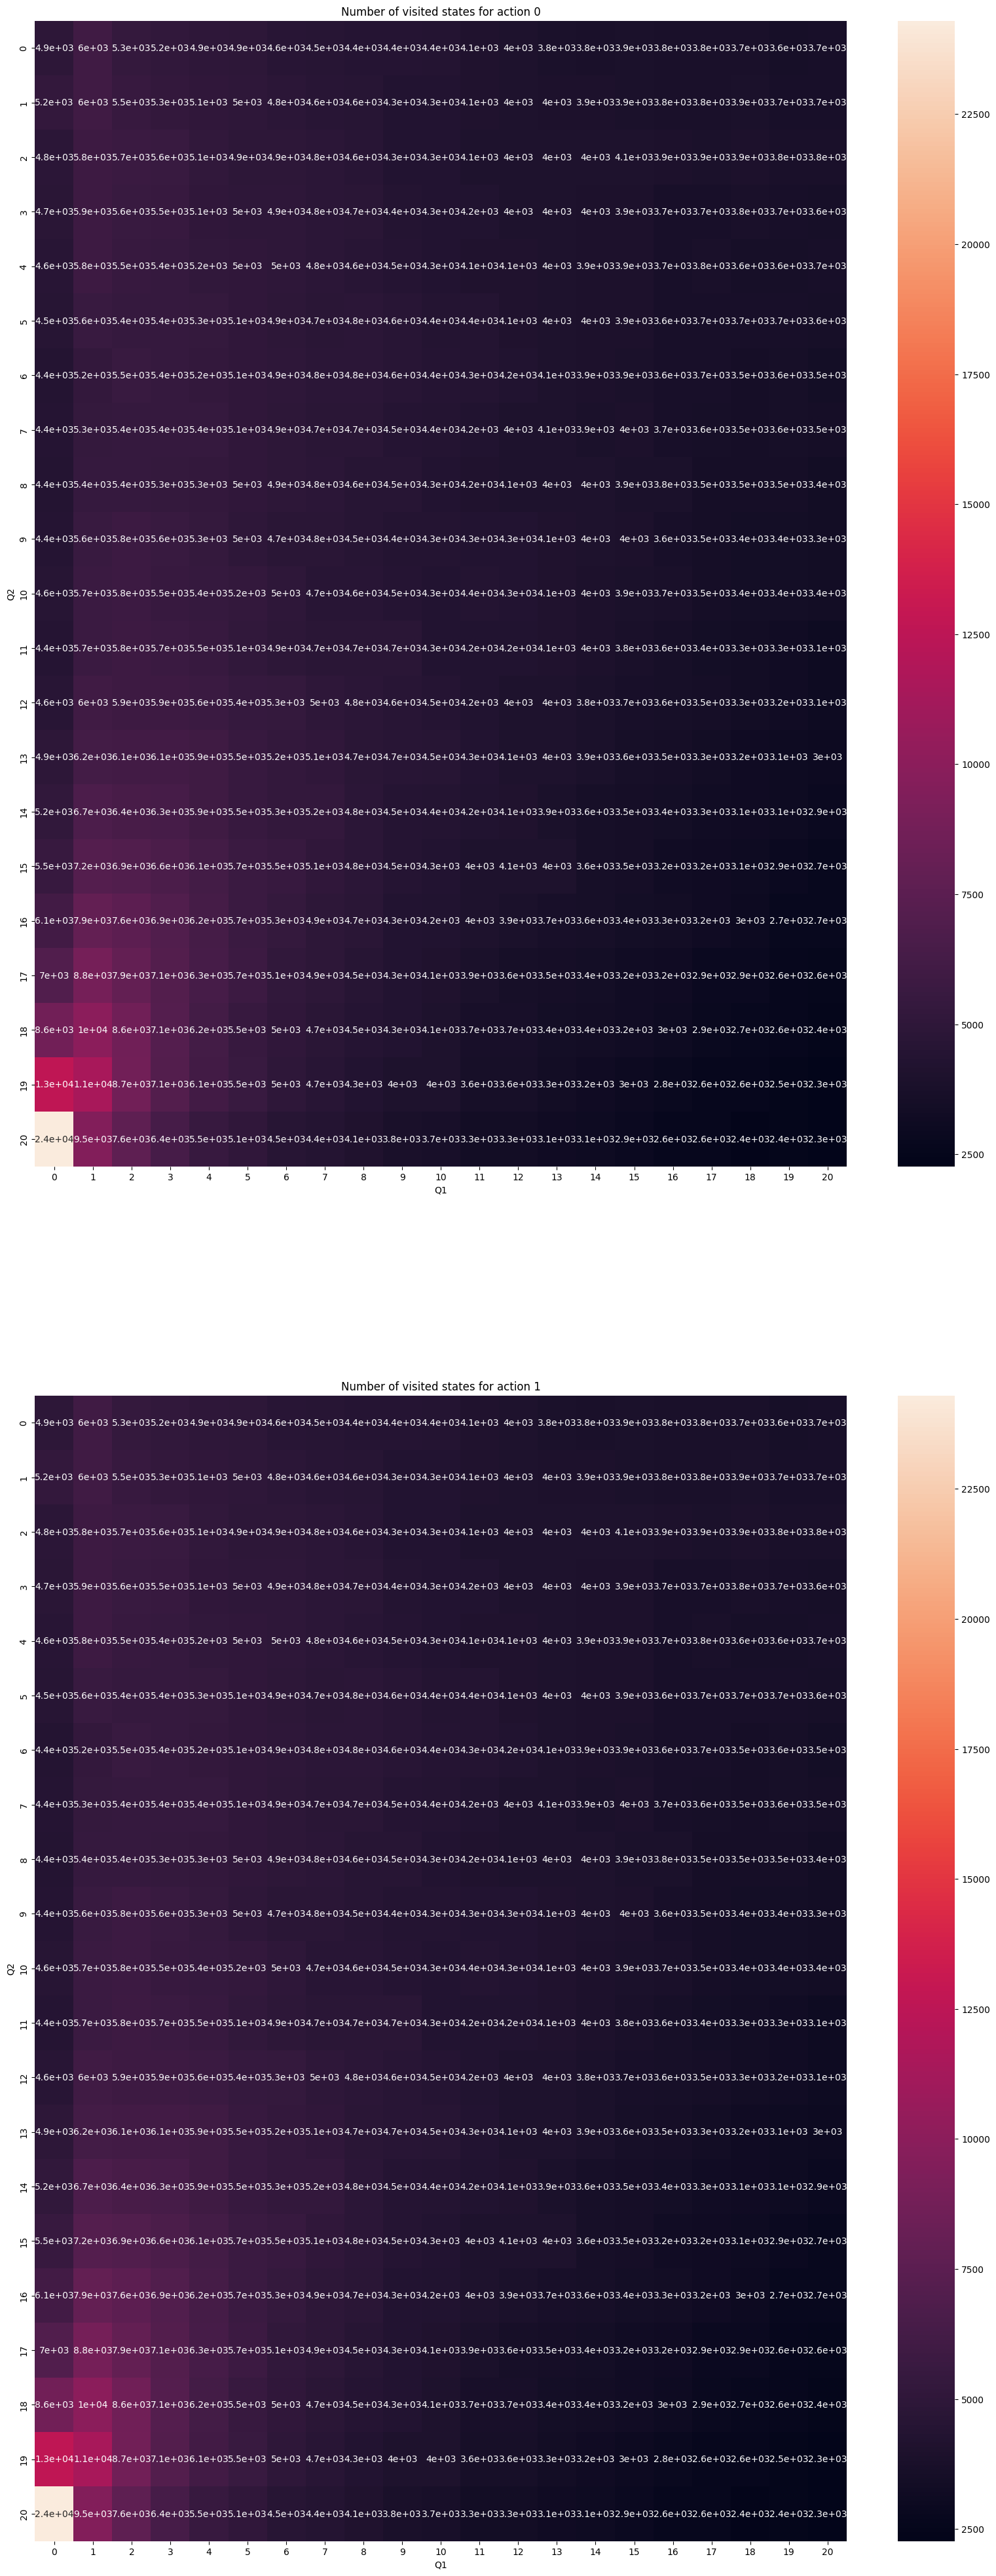

In [239]:
# Plot the number of visited states
fig, ax = plt.subplots(2, 1, figsize=(20, 50))
sns.heatmap(visited_states[:, :, 0], ax=ax[0], annot=True)
sns.heatmap(visited_states[:, :, 1], ax=ax[1], annot=True)
ax[0].set_title("Number of visited states for action 0")
ax[1].set_title("Number of visited states for action 1")
ax[0].set_xlabel("Q1")
ax[0].set_ylabel("Q2")
ax[1].set_xlabel("Q1")
ax[1].set_ylabel("Q2")
plt.show()